In [1]:
import numpy as np

# Sample toy dataset (binary classification)
# Features: [feature1, feature2]
# Labels: 0 or 1
X = np.array([
    [2.7, 2.5],
    [1.3, 1.5],
    [3.1, 3.0],
    [2.0, 2.2],
    [1.0, 1.1],
    [1.2, 0.9],
    [3.2, 2.8],
    [2.8, 3.0]
])
y = np.array([0, 0, 1, 0, 0, 0, 1, 1])

# Calculate Gini impurity
def gini(y):
    classes, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return 1 - np.sum(probabilities ** 2)

# Split dataset by feature index and threshold
def split_dataset(X, y, feature_index, threshold):
    left_idx = X[:, feature_index] <= threshold
    right_idx = X[:, feature_index] > threshold
    return X[left_idx], y[left_idx], X[right_idx], y[right_idx]

# Find the best split
def best_split(X, y):
    best_gini = float('inf')
    best_idx, best_thresh = None, None
    for feature_index in range(X.shape[1]):
        thresholds = np.unique(X[:, feature_index])
        for threshold in thresholds:
            _, y_left, _, y_right = split_dataset(X, y, feature_index, threshold)
            if len(y_left) == 0 or len(y_right) == 0:
                continue
            g = (len(y_left) * gini(y_left) + len(y_right) * gini(y_right)) / len(y)
            if g < best_gini:
                best_gini = g
                best_idx = feature_index
                best_thresh = threshold
    return best_idx, best_thresh

# Recursive tree building
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value  # only for leaf nodes

def build_tree(X, y, depth=0, max_depth=3):
    # Stop if pure or max depth reached
    if len(np.unique(y)) == 1 or depth >= max_depth:
        leaf_value = np.bincount(y).argmax()
        return Node(value=leaf_value)

    feature_index, threshold = best_split(X, y)
    if feature_index is None:
        leaf_value = np.bincount(y).argmax()
        return Node(value=leaf_value)

    X_left, y_left, X_right, y_right = split_dataset(X, y, feature_index, threshold)

    left_child = build_tree(X_left, y_left, depth + 1, max_depth)
    right_child = build_tree(X_right, y_right, depth + 1, max_depth)

    return Node(feature_index, threshold, left_child, right_child)

# Prediction
def predict(sample, tree):
    if tree.value is not None:
        return tree.value
    if sample[tree.feature_index] <= tree.threshold:
        return predict(sample, tree.left)
    else:
        return predict(sample, tree.right)

# Build and test the tree
tree = build_tree(X, y)

# Test prediction
for i, sample in enumerate(X):
    print(f"Sample {sample}, Predicted: {predict(sample, tree)}, Actual: {y[i]}")


Sample [2.7 2.5], Predicted: 0, Actual: 0
Sample [1.3 1.5], Predicted: 0, Actual: 0
Sample [3.1 3. ], Predicted: 1, Actual: 1
Sample [2.  2.2], Predicted: 0, Actual: 0
Sample [1.  1.1], Predicted: 0, Actual: 0
Sample [1.2 0.9], Predicted: 0, Actual: 0
Sample [3.2 2.8], Predicted: 1, Actual: 1
Sample [2.8 3. ], Predicted: 1, Actual: 1


## We have the following 

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import networkx as nx
from sklearn.datasets import load_breast_cancer, load_digits, load_iris
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay
)

### Train a decision tree on the Iris data

In [16]:
iris = load_iris()
X, y = iris.data, iris.target
feature_names = iris.feature_names
clf = DecisionTreeClassifier(max_depth=3, random_state=42)  # keep it small
clf.fit(X, y)


,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


### Turn the sklearn tree into a networkx graph

In [17]:
G = nx.DiGraph()
node_labels = {}

# helper: pretty‑print the decision rule for a node
def node_rule(node_id):
    if clf.tree_.children_left[node_id] == -1:        # leaf
        # the majority class in this leaf
        class_id = np.argmax(clf.tree_.value[node_id])
        return f"leaf\nclass={class_id}"
    else:
        feature = clf.tree_.feature[node_id]
        threshold = clf.tree_.threshold[node_id]
        return f"{feature_names[feature]}\n≤ {threshold:.2f}"

for node_id in range(clf.tree_.node_count):
    G.add_node(node_id)
    node_labels[node_id] = node_rule(node_id)

    # connect children
    left = clf.tree_.children_left[node_id]
    right = clf.tree_.children_right[node_id]
    if left != -1:
        G.add_edge(node_id, left)
    if right != -1:
        G.add_edge(node_id, right)


### Run for one sample

In [18]:
sample_id = 0                   
X_sample = X[sample_id:sample_id+1]
node_indicator = clf.decision_path(X_sample)
sample_nodes = node_indicator.indices[
    node_indicator.indptr[0]:node_indicator.indptr[1]
].tolist()

print(f"Sample {sample_id} will visit nodes: {sample_nodes}")

Sample 0 will visit nodes: [0, 1]


### Convert this to a Graph

In [19]:
pos = nx.nx_agraph.graphviz_layout(G, prog="dot") 

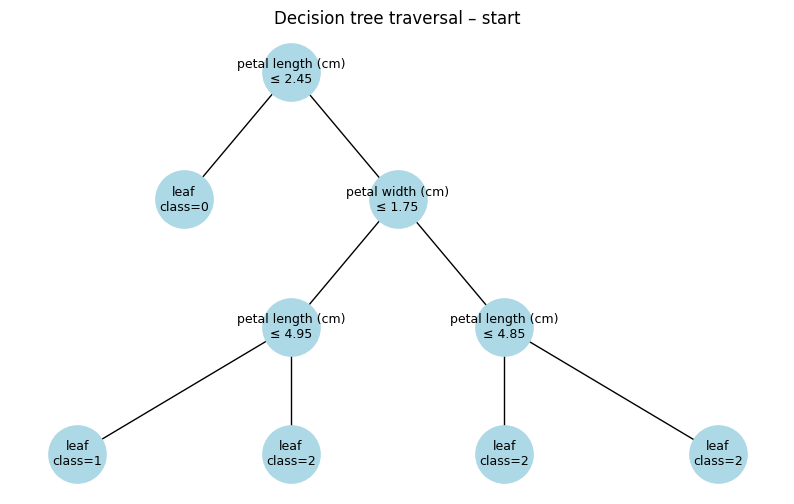

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.axis('off')

default_color = "#add8e6"
highlight_color = "#ff9900"

def init():
    ax.clear()
    plt.axis('off')
    nx.draw_networkx(G, pos, ax=ax, node_color=default_color,
                     node_size=1700, font_size=9, font_color='black',
                     labels=node_labels, arrows=False)
    ax.set_title("Decision tree traversal – start")
    return ax,

def update(frame):
    ax.clear()
    plt.axis('off')
    nx.draw_networkx(G, pos, ax=ax, node_color=default_color,
                     node_size=1700, font_size=9, font_color='black',
                     labels=node_labels, arrows=False)

    node_to_highlight = sample_nodes[frame]
    nx.draw_networkx_nodes(G, pos, nodelist=[node_to_highlight], ax=ax,
                           node_color=highlight_color, node_size=1700)

    node = node_to_highlight
    if clf.tree_.children_left[node] != -1:            # decision node
        feature = clf.tree_.feature[node]
        threshold = clf.tree_.threshold[node]
        feat_val = X_sample[0, feature]
        decision = "≤" if feat_val <= threshold else ">"
        ax.text(0.5, -0.1,
                f"Decision: {feature_names[feature]} {decision} {threshold:.2f}\n"
                f"Sample value = {feat_val:.2f}",
                ha='center', va='center', transform=ax.transAxes,
                fontsize=10, color="darkgreen")
    else:
        class_id = np.argmax(clf.tree_.value[node])
        ax.text(0.5, -0.1,
                f"Reached leaf: class={class_id}",
                ha='center', va='center', transform=ax.transAxes,
                fontsize=10, color="darkred")

    ax.set_title(f"Step {frame+1}/{len(sample_nodes)} – node {node_to_highlight}")
    return ax,

anim = FuncAnimation(fig, update, frames=len(sample_nodes),
                     init_func=init, blit=False, repeat=False,
                     interval=1500)      # 1.5s per node

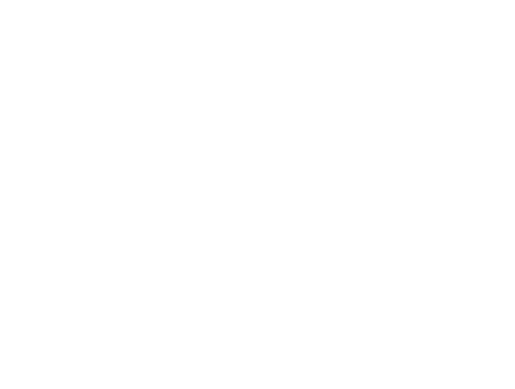

In [21]:
from IPython.display import HTML
HTML(anim.to_jshtml())

### A Fairly Large Problem

#### NMIST

In [22]:

from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay
)

from sklearn.preprocessing import label_binarize


# Load data

In [26]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y = y.astype(int)

# 2. Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [27]:
# 3. Train & prune
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(
    criterion='gini',
    max_depth=20,                 # start with a modest depth
    min_samples_leaf=5,
    random_state=42,
    class_weight='balanced'
)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [28]:
path = dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
# pick alpha that gives <= 200 leaves
alpha = ccp_alphas[np.where(path.impurities < 1e-1)[0][0]]
pruned_dt = DecisionTreeClassifier(
    ccp_alpha=alpha, random_state=42)
pruned_dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [29]:
classes = np.unique(y_test)
y_true_ohe = label_binarize(y_test, classes=classes)   # shape (n_samples, n_classes)

In [30]:
y_true_ohe 

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]], shape=(14000, 10))

In [31]:
y_proba = pruned_dt.predict_proba(X_test)

In [32]:
y_proba

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(14000, 10))

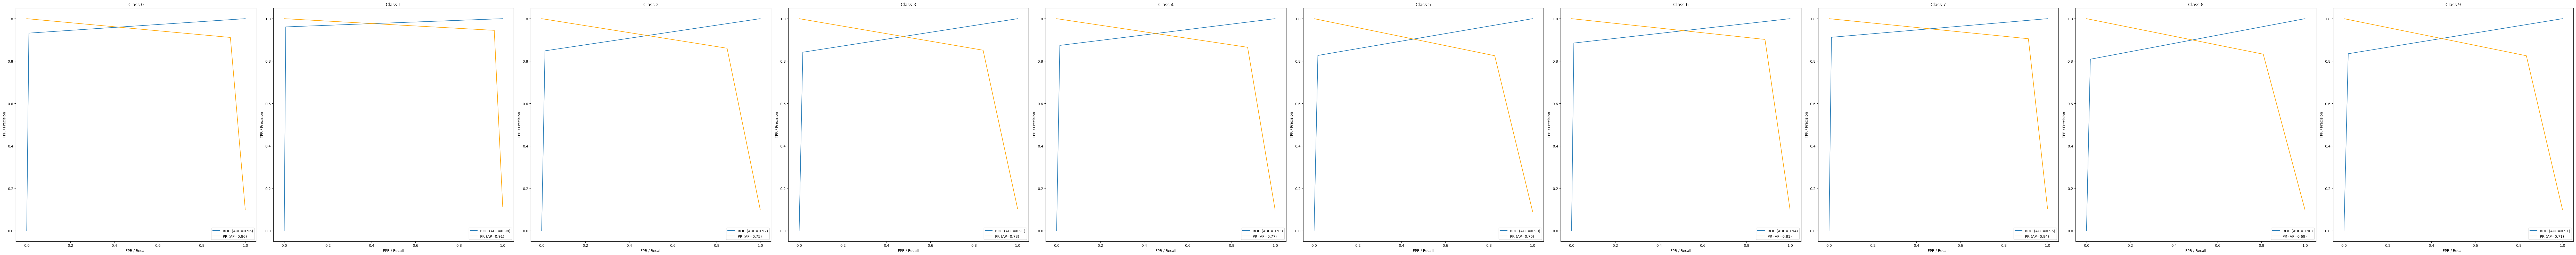

In [33]:
n_classes = len(classes)

plt.figure(figsize=(n_classes*10, 10))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_ohe[:, i], y_proba[:, i])
    roc_auc = roc_auc_score(y_true_ohe[:, i], y_proba[:, i])

    precision, recall, _ = precision_recall_curve(y_true_ohe[:, i], y_proba[:, i])
    avg_prec = average_precision_score(y_true_ohe[:, i], y_proba[:, i])

    ax = plt.subplot(1, n_classes, i+1)
    ax.plot(fpr, tpr, label=f'ROC (AUC={roc_auc:.2f})')
    ax.plot(recall, precision, label=f'PR (AP={avg_prec:.2f})', color='orange')
    ax.set_title(f'Class {classes[i]}')
    ax.set_xlabel('FPR / Recall')
    ax.set_ylabel('TPR / Precision')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

### Micro and Macro 

In [34]:
# Micro & Macro AUC
micro_roc_auc = roc_auc_score(y_true_ohe, y_proba, average='micro')
macro_roc_auc = roc_auc_score(y_true_ohe, y_proba, average='macro')

# Micro & Macro PR
micro_ap = average_precision_score(y_true_ohe, y_proba, average='micro')
macro_ap = average_precision_score(y_true_ohe, y_proba, average='macro')

print(f"Micro ROC‑AUC: {micro_roc_auc:.3f}")
print(f"Macro ROC‑AUC: {macro_roc_auc:.3f}")
print(f"Micro AP: {micro_ap:.3f}")
print(f"Macro AP: {macro_ap:.3f}")

Micro ROC‑AUC: 0.930
Macro ROC‑AUC: 0.929
Micro AP: 0.777
Macro AP: 0.776


### Cross Validation

In [35]:
y_proba_cv = cross_val_predict(
    dt, X, y, cv=5, method='predict_proba', n_jobs=-1)

In [36]:
X.shape


(70000, 784)

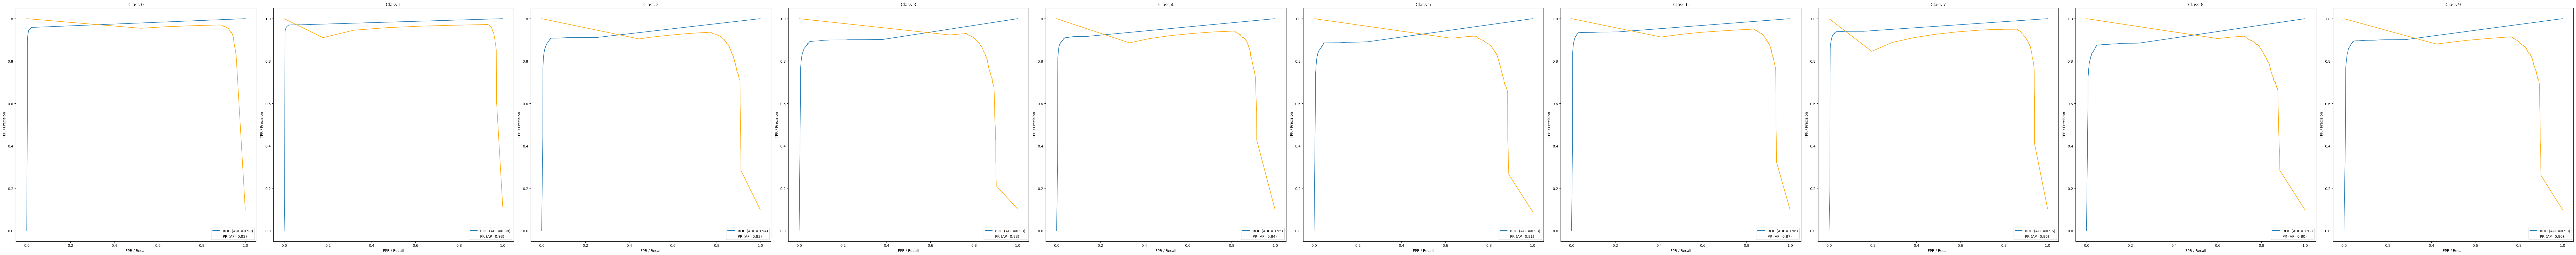

In [37]:
classes = np.unique(y)
y_true_ohe = label_binarize(y, classes=classes)

n_classes = len(classes)

plt.figure(figsize=(n_classes*10, 10))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_ohe[:, i], y_proba_cv[:, i])
    roc_auc = roc_auc_score(y_true_ohe[:, i], y_proba_cv[:, i])

    precision, recall, _ = precision_recall_curve(y_true_ohe[:, i], y_proba_cv[:, i])
    avg_prec = average_precision_score(y_true_ohe[:, i], y_proba_cv[:, i])

    ax = plt.subplot(1, n_classes, i+1)
    ax.plot(fpr, tpr, label=f'ROC (AUC={roc_auc:.2f})')
    ax.plot(recall, precision, label=f'PR (AP={avg_prec:.2f})', color='orange')
    ax.set_title(f'Class {classes[i]}')
    ax.set_xlabel('FPR / Recall')
    ax.set_ylabel('TPR / Precision')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()